In [1]:
import json
import numpy as np
from scipy.linalg import block_diag

import seaborn as sns
import matplotlib.pyplot as plt

from inference import pdfs
from inference.gps import GP_generator
from loader import build_FK, load_data

#from inference.plotting_utils import load_style
#plt.style.use(load_style())

In [2]:
fk_grid=np.geomspace(1e-6,1.,50)
datasets_list=[
    #'NMCPD_dw_ite',
    #'NMC',
    'SLACP_dwsh',
    'SLACD_dw_ite',
    'BCDMSP_dwsh',
    'BCDMSD_dw_ite',
    'CHORUSNUPb_dw_ite',
    'CHORUSNBPb_dw_ite',
    'NTVNUDMNFe_dw_ite',
    'NTVNBDMNFe_dw_ite',
    'HERACOMBNCEM',
    'HERACOMBNCEP460', 
    'HERACOMBNCEP575',
    'HERACOMBNCEP820'
    'HERACOMBNCEP920',
    'HERACOMBCCEM',
    'HERACOMBCCEP',
    'HERACOMB_SIGMARED_B',
    'HERACOMB_SIGMARED_C'
]




_, cov = load_data(datasets_list)
FK = build_FK(datasets_list, fk_grid)

In [3]:
f = pdfs.get_evolution_xpdfs("NNPDF40_nnlo_as_01180", 0, fk_grid, 1.65)
y = FK@f

In [4]:
y

array([0.97836914, 0.92868133, 0.51353334, ..., 0.01377569, 0.00546906,
       0.00425959])

In [5]:
# NOTE: in DIS the FK tables are convoluted with xf.
# when using GPs the evolution basis is given by
# xS, xg, V, V3, V8, V15, T3, T8, T15
# therefore for the flavors V, V3, V8, V15, T3, T8, T15 I have to reabsorb
# the factor x in the FK table

# reformulate in terms of gp pdfs and fks

# pdfs
f_gp_xS_xg = f[:2*fk_grid.size]

division_grid = np.concatenate([fk_grid for i in range(2,9)])
f_gp_V_V3_V8_V15_T3_T8_T15 = np.divide(f[2*fk_grid.size:], division_grid)
f_gp = np.concatenate([f_gp_xS_xg, f_gp_V_V3_V8_V15_T3_T8_T15])

# fk 
FK_xS_xg = FK[:,:2*fk_grid.size]
FK_V_V3_V8_V15_T3_T8_T15 = np.multiply(FK[:,2*fk_grid.size:], division_grid)
FK_gp = np.concatenate([FK_xS_xg, FK_V_V3_V8_V15_T3_T8_T15], axis=1)

FK_gp @ f_gp


array([0.97836914, 0.92868133, 0.51353334, ..., 0.01377569, 0.00546906,
       0.00425959])

In [6]:
y = FK_gp @ f_gp

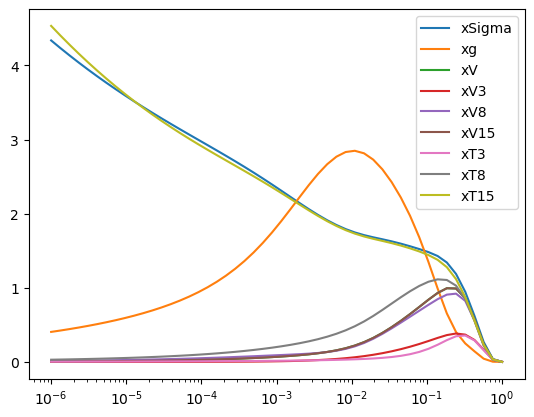

In [7]:
labels=["xSigma", "xg", "xV", "xV3", "xV8", "xV15", "xT3", "xT8", "xT15"]
ff = f.reshape((9,fk_grid.size))
for flav in range(0,9):
    plt.plot(fk_grid, ff[flav,:], "-", label=labels[flav] )

plt.xscale("log")
#plt.ylim([-50,250])
plt.legend()

In [8]:
y.shape

(2317,)

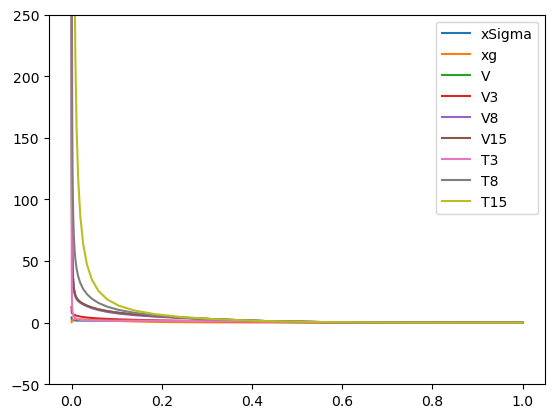

In [9]:
labels=["xSigma", "xg", "V", "V3", "V8", "V15", "T3", "T8", "T15"]
ff_gp = f_gp.reshape((9,fk_grid.size))
for flav in range(0,9):
    plt.plot(fk_grid, ff_gp[flav,:], "-", label=labels[flav] )

plt.xscale("linear")
plt.ylim([-50,250])
plt.legend()

In [50]:
# generate GP
theta = {
    "sigma": [5, 5, 3, 3, 3, 3, 3, 3, 3],  
    "l0": [1, 1, 4, 4, 4, 4, 4, 4, 4],
    "alpha": [-0.01, -0.01, -0.2, -0.1, -0.1, -0.1, -0.1, -0.2, -0.1]
}
gp0 = GP_generator("Gibbs", fk_grid, y, cov, FK_gp, kin_lim=True, theta=theta)

In [51]:
# define a grid for f*
grids_smallx = np.geomspace(1e-6, 0.1, 30)
grids_largex = np.linspace(0.1, 1., 30)
grids = np.concatenate([grids_smallx, grids_largex])
ngrids = grids.size

In [52]:
# compute mean and cov for prior and posterior, no sumrules 
mean_prior0a, cov_prior0a = gp0.get_prior(grids)

In [53]:
mean_posterior0a, cov_posterior0a = gp0.get_posterior(grids) #, sumrules=True

In [54]:
def sample_GP(mean, cov, nsamples=1000):
    samples = np.random.multivariate_normal(mean, cov, size=nsamples)
    cv = samples.mean(axis=0)
    std = samples.std(axis=0)

    return cv, std

In [55]:
cv, std = sample_GP(mean_posterior0a, cov_posterior0a)

/var/folders/gy/y58f67rs4x94dgyc4jg06lsr0000gn/T/ipykernel_6855/1255785599.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, size=nsamples)


In [61]:
res = np.array([cv[i*ngrids:(i+1)*ngrids] for i in range(0,9)])
err = np.array([std[i*ngrids:(i+1)*ngrids] for i in range(0,9)])
ff = (pdfs.get_evolution_pdfs("NNPDF40_nnlo_as_01180", 0, grids, 1.65)).reshape((9,ngrids))

In [62]:
ff.shape

(9, 60)

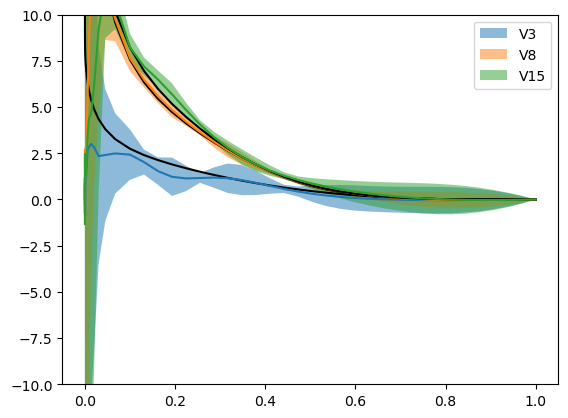

In [66]:
labels=["xSigma", "xg", "V", "V3", "V8", "V15", "T3", "T8", "T15"]

for flav in range(3,6):
    plt.plot(grids, ff[flav,:], "-", color="black")
    plt.plot(grids, res[flav,:], "-")
    plt.fill_between(grids, res[flav,:] - err[flav,:], res[flav,:] + err[flav,:], label=labels[flav], alpha=0.5)

plt.xscale("linear")
plt.ylim([-10,10])
plt.legend()

In [ ]:
mean_posterior0a, cov_posterior0a = gp0.get_posterior(grids,sumrules=True)

In [ ]:
res = np.array([0.27421451, 0.25034094, 0.21609374, 0.18032335, 0.13673181,
       0.09518202, 0.29106915, 0.26306709, 0.22284892, 0.18021   ,
       0.13527673, 0.0978706 , 0.31128271, 0.28601126, 0.2323176 ,
       0.18349621, 0.15934451, 0.11812423, 0.09310508, 0.29078159,
       0.25297349, 0.203683  , 0.16068592, 0.12053872, 0.07569599,
       0.29570578, 0.24592589, 0.18561077, 0.12644486, 0.05821807,
       0.21661449, 0.11595337, 0.15377919, 0.07106426, 0.13493924,
       0.05897014, 0.03724316])

In [ ]:
y